In [1]:
import pandas as pd
import numpy as np

from calc_fx import *

%load_ext autoreload
%autoreload 2

In [2]:
# DATA_DIR = config("DATA_DIR")

DATA_DIR = r"../../../FS-project_files/FX-files"

# Initial Pull and analysis

FX_MONTHLY = r"fx_monthly_data.parquet"
FX_DAILY = r"fx_daily_data.parquet"
FX_FORWARD = r"fx_forward_points.parquet"
FX_SPOT_RATES = r"fx_spot_rates.parquet"
FX_INTEREST_RATES = r"fx_interest_rates.parquet"

In [3]:
fx_month = pd.read_parquet(f"{DATA_DIR}/{FX_MONTHLY}")
fx_day = pd.read_parquet(f"{DATA_DIR}/{FX_DAILY}")
fx_forward = pd.read_parquet(f"{DATA_DIR}/{FX_FORWARD}")
fx_spot = pd.read_parquet(f"{DATA_DIR}/{FX_SPOT_RATES}")
fx_interest = pd.read_parquet(f"{DATA_DIR}/{FX_INTEREST_RATES}")

In [4]:
fx_data = prepare_fx_data(fx_spot, fx_forward, fx_interest)

In [5]:
ret_list = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NZD", "SEK", "USD"]

In [7]:
def implied_daily_fx_returns(fx_data, currency_list):
    """
    This function returns implied daily return time series on foreign currencies

    Parameters:
    fx_data: Foreign currency data containing spot exchange rate and interest rate of currency
        CUR_spot is the spot exchange rate of 1USD to CUR
        CUR_ir is the annualized interest rate of CUR on that day in percent space (7.0 = 7%)

    currency_list: list of currencies we generate returns for

    Output:
    fx_df: Foreign currency implied daily return time series
        absolute returns are used here (not annualized, not log scaled)
        CUR_return is the daily return of CUR on the day (not in % space)
    """
    fx_df = fx_data.copy()
    fx_df = fx_df.fillna(method="ffill")

    # tracking returns columns
    ret_cols = ["USD_return"]

    for curr_name in ret_list:
        int_col = f"{curr_name}_ir"

        if curr_name == "USD":
            fx_df["USD_return"] = fx_df[int_col] / (
                365 * 100
            )  # change to daily absolute returns

            continue

        spot_col = f"{curr_name}_spot"
        fx_df[f"{spot_col}_ratio"] = fx_df[spot_col] / fx_df[spot_col].shift(
            1
        )  # change in spot price ratio
        curr_ret_col = f"{curr_name}_return"

        fx_df[curr_ret_col] = (
            fx_df[f"{spot_col}_ratio"] * fx_df[int_col]
        )  # combine spot change and interest
        ret_cols.append(curr_ret_col)

    # filter just for returns
    fx_df = fx_df[ret_cols]
    return fx_df

In [8]:
impl_fx_ret = implied_daily_fx_returns(fx_data, ret_list)

C:\Users\xuv14\AppData\Local\Temp\ipykernel_2816\4100816072.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fx_df = fx_df.fillna(method='ffill')


<Axes: xlabel='index'>

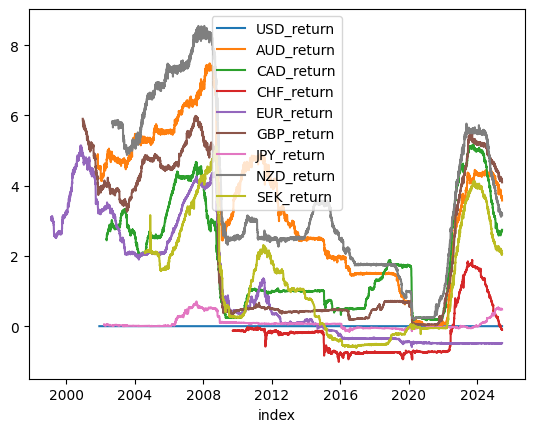

In [9]:
impl_fx_ret.plot()